# Demo Deep Belief Network para identificar TIPOS de IRIS
  Nota: se usa el modelo definido en https://github.com/albertbup/deep-belief-network

0) Instalar paquete de DBN: 
( para más info ver https://github.com/albertbup/deep-belief-network/blob/master/README.md )

In [1]:
#@title Chequea que sea una sesión GPU
# nota se debe indicar la versión 1 de TF para compatibilidad del código
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

TensorFlow 1.x selected.
1.15.2
Found GPU at: /device:GPU:0


In [2]:
#@title Instala el paquete 
#!pip install git+git://github.com/albertbup/deep-belief-network.git@master_gpu
!git clone https://github.com/albertbup/deep-belief-network.git
%cd deep-belief-network
!pip install -r requirements.txt

fatal: destination path 'deep-belief-network' already exists and is not an empty directory.
/content/deep-belief-network
  Using cached https://files.pythonhosted.org/packages/fc/d1/45be1144b03b6b1e24f9a924f23f66b4ad030d834ad31fb9e5581bd328af/numpy-1.16.4-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/22/41/b1538a75309ae4913cdbbdc8d1cc54cae6d37981d2759532c1aa37a41121/scipy-0.18.1.tar.gz
  Using cached https://files.pythonhosted.org/packages/f1/dc/5fb2834511eef6f86e17b6ec41c0c7a60733f79633827e75aaa55029a9fa/scikit-learn-0.18.1.tar.gz
ERROR: Could not find a version that satisfies the requirement tensorflow==1.5.0 (from -r requirements.txt (line 4)) (from versions: 1.13.0rc1, 1.13.0rc2, 1.13.1, 1.13.2, 1.14.0rc0, 1.14.0rc1, 1.14.0, 1.15.0rc0, 1.15.0rc1, 1.15.0rc2, 1.15.0rc3, 1.15.0, 1.15.2, 1.15.3, 1.15.4, 1.15.5, 2.0.0a0, 2.0.0b0, 2.0.0b1, 2.0.0rc0, 2.0.0rc1, 2.0.0rc2, 2.0.0, 2.0.1, 2.0.2, 2.0.3, 2.0.4, 2.1.0rc0, 2.1.0rc1, 2.1.0rc2, 2.1.0, 2.1.1,

1) Cargar librerías:

In [3]:
#@title Librerías a usar

# nota se debe indicar la versión 1 de TF para compatibilidad del código
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

from dbn.tensorflow import SupervisedDBNClassification # ojo que usa GPU
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics.classification import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt

print ("Librerías cargadas.")

1.15.2

Librerías cargadas.


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


2) Cargar los datos:

In [4]:
# monta Google Drive:
# Nota: la primera vez se debe confirmar el uso logueandose en "Google Drive File Stream" y obteniendo código de autentificación.
from google.colab import drive
drive.mount('/content/gdrive')

# directorio local en Google Drive
path = '/content/gdrive/My Drive/IA/demo IRIS'  #@param {type:"string"}

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
## selección de los parámetros 

#@markdown ### Archivo de datos a utilizar:
archivo_datos = '/datos/IRIS.csv'  #@param {type:"string"}
#@markdown ### Nombre del atributo clase / objetivo:
atributo_clase = 'Clase' #@param {type:"string"}
#@markdown ### Descripción de los valores del atributo clase / objetivo:  (nota: siempre debe comienzar en 0, por lo que si no tiene valor 0, agregar "na")
nombre_clases = 'na, Setosa, Versicolor, Virginica' #@param {type:"string"}
#@markdown ### Porcentaje de datos para usar en el entrenamiento:
proporcion_porcentaje_datos_entrenamiento =   70#@param {type:"integer"}

## aplicación de los parámetros elegidos

# define nombre atributo de CLASE para ejemplo IRIS
ClassAttributeName = atributo_clase

# define valores de clases para ejemplo IRIS
CLASES = [ ]
for val in nombre_clases.split(','):
  CLASES.append( val )

# determina la proporción a usar para entrenar y probar
if proporcion_porcentaje_datos_entrenamiento>100:
  propTrain = 1
elif proporcion_porcentaje_datos_entrenamiento<1:
  propTrain = 0.1
else:
  propTrain = proporcion_porcentaje_datos_entrenamiento/100

print("Configuración definida de ", archivo_datos)
print("Atributo clase: ", ClassAttributeName, ": ", CLASES)

Configuración definida de  /datos/IRIS.csv
Atributo clase:  Clase :  ['na', ' Setosa', ' Versicolor', ' Virginica']


In [6]:
#@title Cargar datos

# configura para que muestre todas las columnas y filas
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

# Carga los datos del CSV y muestra los primeros
df = pd.read_csv(path + archivo_datos)
print("\n> Cabecera: ")
print(df.head())
print("\n> Características: ")
print(df.describe())

# genera los datos solo con la clase para entrenar y probar
Y = np.array(df.pop(ClassAttributeName))
X = np.array(df)


> Cabecera: 
   LargoSepalo  AnchoSepalo  LargoPetalo  AnchoPetalo  Clase
0          5.1          3.5          1.4          0.2      1
1          4.9          3.0          1.4          0.2      1
2          4.7          3.2          1.3          0.2      1
3          4.6          3.1          1.5          0.2      1
4          5.0          3.6          1.4          0.2      1

> Características: 
       LargoSepalo  AnchoSepalo  LargoPetalo  AnchoPetalo       Clase
count   150.000000   150.000000   150.000000   150.000000  150.000000
mean      5.843333     3.054000     3.758667     1.198667    2.000000
std       0.828066     0.433594     1.764420     0.763161    0.819232
min       4.300000     2.000000     1.000000     0.100000    1.000000
25%       5.100000     2.800000     1.600000     0.300000    1.000000
50%       5.800000     3.000000     4.350000     1.300000    2.000000
75%       6.400000     3.300000     5.100000     1.800000    3.000000
max       7.900000     4.400000     6.9

In [7]:
#@title Normalizar datos de entrada (opcional)

print("10 primeros datos de Entrada antes de normalizar: ")
print(X[:10])

from sklearn import preprocessing

# elegir el método de normalización
scaler = preprocessing.MinMaxScaler()
#scaler = preprocessing.MaxAbsScaler()

# normaliza los datos de entrada
X = scaler.fit_transform(X)

print("\n\n10 primeros datos de Entrada después de normalizar: ")
print(X[:10])

10 primeros datos de Entrada antes de normalizar: 
[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]
 [5.4 3.9 1.7 0.4]
 [4.6 3.4 1.4 0.3]
 [5.  3.4 1.5 0.2]
 [4.4 2.9 1.4 0.2]
 [4.9 3.1 1.5 0.1]]


10 primeros datos de Entrada después de normalizar: 
[[0.22222222 0.625      0.06779661 0.04166667]
 [0.16666667 0.41666667 0.06779661 0.04166667]
 [0.11111111 0.5        0.05084746 0.04166667]
 [0.08333333 0.45833333 0.08474576 0.04166667]
 [0.19444444 0.66666667 0.06779661 0.04166667]
 [0.30555556 0.79166667 0.11864407 0.125     ]
 [0.08333333 0.58333333 0.06779661 0.08333333]
 [0.19444444 0.58333333 0.08474576 0.04166667]
 [0.02777778 0.375      0.06779661 0.04166667]
 [0.16666667 0.45833333 0.08474576 0.        ]]


In [8]:
#@title Preparar datos

# separa al azar usando muestreo estratificado con proporción indicada
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=(1-propTrain), stratify=Y)

# muestra resultados
print("> Para Ambos: ")
print(" - dictMapeo: ", CLASES)

print("\n> Para Entrenamiento: ")
print(" - x_train (cant ejemplos, datos entrada): ", x_train.shape)
print(" - y_train (cant): ", len(y_train))
for i in range(len(CLASES)):
  cant = 0
  for y in y_train:
    if i == y: cant = cant + 1
  print("    ", CLASES[i], "[", i, "]:", cant)

print("\n Para Prueba: ")
print(" - x_test (cant ejemplos, datos entrada): ", x_test.shape)
print(" - y_test (cant): ", len(y_test))
for i in range(len(CLASES)):
  cant = 0
  for y in y_test:
    if i == y: cant = cant + 1
  print("    ", CLASES[i], "[", i, "]:", cant)


> Para Ambos: 
 - dictMapeo:  ['na', ' Setosa', ' Versicolor', ' Virginica']

> Para Entrenamiento: 
 - x_train (cant ejemplos, datos entrada):  (104, 4)
 - y_train (cant):  104
     na [ 0 ]: 0
      Setosa [ 1 ]: 34
      Versicolor [ 2 ]: 35
      Virginica [ 3 ]: 35

 Para Prueba: 
 - x_test (cant ejemplos, datos entrada):  (46, 4)
 - y_test (cant):  46
     na [ 0 ]: 0
      Setosa [ 1 ]: 16
      Versicolor [ 2 ]: 15
      Virginica [ 3 ]: 15


3) Especificar el modelo para la DBN:

In [13]:
#@title Establecer el modelo
dbn_cant_neuronas_capas_ocultas = '128, 64' #@param {type:"string"}
RBM_cant_epocas_entrenamiento = 20 #@param {type:"integer"}
Backprop_cant_epocas_entrenamiento = 750 #@param {type:"integer"}

# cantidad de neuronas ocultas 
hidden_layers = []
for val in dbn_cant_neuronas_capas_ocultas.split(','):
  hidden_layers.append( int(val) )

classifier = SupervisedDBNClassification(hidden_layers_structure = hidden_layers,
learning_rate_rbm=0.05,
learning_rate=0.1,
n_epochs_rbm=RBM_cant_epocas_entrenamiento,
n_iter_backprop=Backprop_cant_epocas_entrenamiento,
batch_size=32,
activation_function='relu',
dropout_p=0.2)

print(classifier)

SupervisedDBNClassification(batch_size=32, dropout_p=0.2, idx_to_label_map=None,
                            l2_regularization=1.0, label_to_idx_map=None,
                            learning_rate=0.1, n_iter_backprop=750,
                            verbose=True)


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


4) Entrenar el modelo de la DBN:

In [14]:
#@title Entrenar
classifier.fit(x_train, y_train)

[START] Pre-training step:
>> Epoch 1 finished 	RBM Reconstruction error 0.353687
>> Epoch 2 finished 	RBM Reconstruction error 0.234689
>> Epoch 3 finished 	RBM Reconstruction error 0.164859
>> Epoch 4 finished 	RBM Reconstruction error 0.139044
>> Epoch 5 finished 	RBM Reconstruction error 0.116469
>> Epoch 6 finished 	RBM Reconstruction error 0.102306
>> Epoch 7 finished 	RBM Reconstruction error 0.090866
>> Epoch 8 finished 	RBM Reconstruction error 0.087472
>> Epoch 9 finished 	RBM Reconstruction error 0.079012
>> Epoch 10 finished 	RBM Reconstruction error 0.076380
>> Epoch 11 finished 	RBM Reconstruction error 0.077311
>> Epoch 12 finished 	RBM Reconstruction error 0.071849
>> Epoch 13 finished 	RBM Reconstruction error 0.067677
>> Epoch 14 finished 	RBM Reconstruction error 0.068484
>> Epoch 15 finished 	RBM Reconstruction error 0.066858
>> Epoch 16 finished 	RBM Reconstruction error 0.060406
>> Epoch 17 finished 	RBM Reconstruction error 0.061492
>> Epoch 18 finished 	RBM Reco

SupervisedDBNClassification(batch_size=32, dropout_p=0.2,
                            idx_to_label_map={0: 1, 1: 3, 2: 2},
                            l2_regularization=1.0,
                            label_to_idx_map={1: 0, 2: 2, 3: 1},
                            learning_rate=0.1, n_iter_backprop=750,
                            verbose=True)


 Resultados: 
Clase predecida es " Setosa"[1], la correcta es " Setosa"[1] 
Clase predecida es " Setosa"[1], la correcta es " Setosa"[1] 
Clase predecida es " Setosa"[1], la correcta es " Setosa"[1] 
Clase predecida es " Setosa"[1], la correcta es " Setosa"[1] 
Clase predecida es " Versicolor"[2], la correcta es " Virginica"[3]! 
Clase predecida es " Setosa"[1], la correcta es " Setosa"[1] 
Clase predecida es " Versicolor"[2], la correcta es " Versicolor"[2] 
Clase predecida es " Versicolor"[2], la correcta es " Virginica"[3]! 
Clase predecida es " Setosa"[1], la correcta es " Setosa"[1] 
Clase predecida es " Setosa"[1], la correcta es " Setosa"[1] 
Clase predecida es " Versicolor"[2], la correcta es " Versicolor"[2] 
Clase predecida es " Setosa"[1], la correcta es " Setosa"[1] 
Clase predecida es " Versicolor"[2], la correcta es " Versicolor"[2] 
Clase predecida es " Versicolor"[2], la correcta es " Versicolor"[2] 
Clase predecida es " Versicolor"[2], la correcta es " Virginica"[3]! 

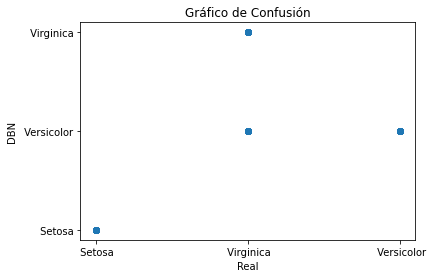

In [15]:
#@title Evaluar el modelo con datos de entrenamiento

# ejecuta el  modelo
y_pred = classifier.predict(x_train)

# calcula la exactitud
#print('\nExactitud: %f' % accuracy_score(y_train, y_pred))

# muestra resultados de la predicción
classPreds = []
classReal = []
cantOK = 0
cantError = 0
print("\n Resultados: ")
for pred_class_id, expec in zip(y_pred, y_train):
    
    classPreds.append(CLASES[pred_class_id])
    classReal.append(CLASES[expec])

    if (pred_class_id == expec): 
      res = ""
      cantOK += 1
    else: 
      res = "!"
      cantError += 1

    print('Clase predecida es "{}"[{}], la correcta es "{}"[{}]{} '.format(
        CLASES[pred_class_id], pred_class_id, CLASES[expec], expec, res))

print('=== Total Ejemplos: {}, con {} predicciones ok y {} errores.'.format(cantOK+cantError, cantOK, cantError))

# gráfico de comparación
plt.title('Gráfico de Confusión')
plt.xlabel('Real')
plt.ylabel('DBN')
plt.scatter(classReal, classPreds)

# muestra reporte de clasificación
print("\n Reporte de Clasificación: ")
print(classification_report(classReal, classPreds))

# muestra matriz de confusion
print('\nMatriz de Confusión: ')
cm = confusion_matrix(classReal, classPreds, labels=CLASES)
cmtx = pd.DataFrame(
    cm, 
    index=['r:{:}'.format(x) for x in CLASES], 
    columns=['p:{:}'.format(x) for x in CLASES]
  )
print(cmtx)
print("\n")


5) Evaluar el modelo de la RNA entrenado:


Exactitud: 0.869565

 Resultados: 
Clase predecida es " Versicolor"[2], la correcta es " Virginica"[3]! 
Clase predecida es " Setosa"[1], la correcta es " Setosa"[1] 
Clase predecida es " Setosa"[1], la correcta es " Setosa"[1] 
Clase predecida es " Setosa"[1], la correcta es " Setosa"[1] 
Clase predecida es " Virginica"[3], la correcta es " Virginica"[3] 
Clase predecida es " Setosa"[1], la correcta es " Setosa"[1] 
Clase predecida es " Versicolor"[2], la correcta es " Virginica"[3]! 
Clase predecida es " Setosa"[1], la correcta es " Setosa"[1] 
Clase predecida es " Setosa"[1], la correcta es " Setosa"[1] 
Clase predecida es " Versicolor"[2], la correcta es " Virginica"[3]! 
Clase predecida es " Versicolor"[2], la correcta es " Virginica"[3]! 
Clase predecida es " Virginica"[3], la correcta es " Virginica"[3] 
Clase predecida es " Versicolor"[2], la correcta es " Versicolor"[2] 
Clase predecida es " Virginica"[3], la correcta es " Virginica"[3] 
Clase predecida es " Versicolor"[2], l

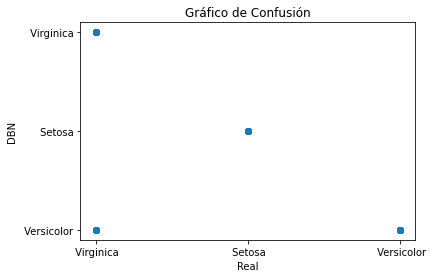

In [16]:
#@title Evaluar el modelo con datos de prueba

# ejecuta el  modelo
y_pred = classifier.predict(x_test)

# calcula la exactitud
print('\nExactitud: %f' % accuracy_score(y_test, y_pred))

# muestra resultados de la predicción
classPreds = []
classReal = []
cantOK = 0
cantError = 0
print("\n Resultados: ")
for pred_class_id, expec in zip(y_pred, y_test):
    
    classPreds.append(CLASES[pred_class_id])
    classReal.append(CLASES[expec])

    if (pred_class_id == expec): 
      res = ""
      cantOK += 1
    else: 
      res = "!"
      cantError += 1

    print('Clase predecida es "{}"[{}], la correcta es "{}"[{}]{} '.format(
        CLASES[pred_class_id], pred_class_id, CLASES[expec], expec, res))

print('=== Total Ejemplos: {}, con {} predicciones ok y {} errores.'.format(cantOK+cantError, cantOK, cantError))

# gráfico de comparación
plt.title('Gráfico de Confusión')
plt.xlabel('Real')
plt.ylabel('DBN')
plt.scatter(classReal, classPreds)

# muestra reporte de clasificación
print("\n Reporte de Clasificación: ")
print(classification_report(classReal, classPreds))

# muestra matriz de confusion
print('\nMatriz de Confusión: ')
cm = confusion_matrix(classReal, classPreds, labels=CLASES)
cmtx = pd.DataFrame(
    cm, 
    index=['r:{:}'.format(x) for x in CLASES], 
    columns=['p:{:}'.format(x) for x in CLASES]
  )
print(cmtx)
print("\n")
